In [ ]:
!ls drive/MyDrive/Speech\ Recognition\ Data

dev_labels.npy	dev.npy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dev = np.load('drive/MyDrive/Speech Recognition Data/dev.npy', encoding='bytes', allow_pickle=True)
dev_labels = np.load('drive/MyDrive/Speech Recognition Data/dev_labels.npy', encoding='bytes', allow_pickle=True)

In [ ]:
total_frames = 0
for i in dev:
    total_frames += i.shape[0]


In [ ]:
X = np.empty((total_frames, 40))
Y = np.empty((total_frames,), dtype=int)

In [ ]:
idx = 0
for i in range(dev.shape[0]):
    rec = dev[i]
    X[idx:idx+rec.shape[0], :rec.shape[1]] = rec
    Y[idx:idx+rec.shape[0]] = dev_labels[i]
    idx += rec.shape[0]

In [ ]:
# Ref: https://stackoverflow.com/questions/38592324/one-hot-encoding-using-numpy/42874726
def get_one_hot(arr):
    num_classes=138
    res = np.eye(num_classes)[arr.reshape(-1)]
    return res.reshape(list(arr.shape)+[num_classes])

In [ ]:
Y = get_one_hot(Y)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y)

In [ ]:
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model

In [ ]:
def speech_model():
    inp = Input(shape=(40,))
    x = Dense(128, activation='relu')(inp)
    # x = Dense(512, activation='relu')(x)
    out = Dense(138, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out, name='Speech_Simple')
    opt = Adam()
    model.compile(optimizer=opt, loss='categorical_crossentropy')
    return model

In [ ]:
test_model = speech_model()

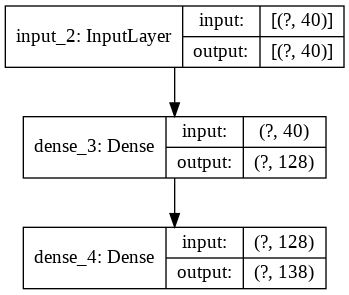

In [ ]:
plot_model(test_model, show_shapes=True)

In [ ]:
hist = test_model.fit(x=X_train, y=Y_train, epochs=20, validation_split=0.3)

Epoch 1/20
10981/10981 [==============================] - 15s 1ms/step - loss: 3.3122 - val_loss: 3.0793
Epoch 2/20
10981/10981 [==============================] - 16s 1ms/step - loss: 3.0229 - val_loss: 2.9920
Epoch 3/20
10981/10981 [==============================] - 15s 1ms/step - loss: 2.9735 - val_loss: 2.9454
Epoch 4/20
10981/10981 [==============================] - 15s 1ms/step - loss: 2.9498 - val_loss: 2.9621
Epoch 5/20
10981/10981 [==============================] - 15s 1ms/step - loss: 2.9347 - val_loss: 2.9721
Epoch 6/20
10981/10981 [==============================] - 15s 1ms/step - loss: 2.9244 - val_loss: 2.9492
Epoch 7/20
10981/10981 [==============================] - 15s 1ms/step - loss: 2.9154 - val_loss: 2.9305
Epoch 8/20
10981/10981 [==============================] - 14s 1ms/step - loss: 2.9085 - val_loss: 2.9472
Epoch 9/20
10981/10981 [==============================] - 15s 1ms/step - loss: 2.9054 - val_loss: 2.9088
Epoch 10/20
10981/10981 [==============================

In [ ]:
Y_pred = test_model.predict(X_test)

In [ ]:
y_hat = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test, axis=1)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
f1_score(y_true, y_hat, average='micro')

0.2653056345772274

# Tesing other models

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(dev, dev_labels)

In [ ]:
class DataProcessor(object):
    def __init__(self, X, Y, context_size):
        self.raw_X = X
        self.raw_Y = Y
        self.k = context_size
        self.X = []
        self.Y = []
        self.idx = []
    
    def _add_context(self):
        for i in range(len(self.raw_X)):
            padded = np.pad(self.raw_X[i], ((self.k, self.k), (0,0)), 'constant', constant_values=0)
            temp_idx = len(self.X) + self.k
            self.X.extend(list(padded))
            self.idx.extend(range(temp_idx, temp_idx+len(self.raw_X[i])))
            self.Y.extend(list(self.raw_Y[i]))
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)


    def prepare_dataset(self):
        self._add_context()
        X = []
        Y = []
        for i in range(len(self.idx)):
            cur_idx = self.idx[i]
            cur_data = self.X[cur_idx-self.k : cur_idx+1+self.k].reshape(-1)
            X.append(cur_data)
            Y.append(self.Y[i])
        Y = np.array(Y)
        Y = self.one_hot_encode(Y)
        return np.array(X), Y
    
    def one_hot_encode(self, Y):
        num_classes=138
        res = np.eye(num_classes)[Y.reshape(-1)]
        return res.reshape(list(Y.shape)+[num_classes])

In [ ]:
train_processor = DataProcessor(X_train, Y_train, 10)
X_train, Y_train = train_processor.prepare_dataset()
test_processor = DataProcessor(X_test, Y_test, 10)
X_test, Y_test = test_processor.prepare_dataset()

In [ ]:
print(Y_train.shape)
X_train.shape

(500625, 138)


(500625, 840)

In [ ]:
class Classifier(object):
    def __init__(self, context_size, frame_size, X_train, Y_train):
        self.k = context_size
        self.frame_dim = frame_size
        self.X_train = X_train
        self.Y_train = Y_train
        self.model = self._create_model()

    
    def _create_model(self):
        # One frame of training. 2k frames in context
        inp = Input(shape=((2*self.k)+1) * 40)
        l1 = Dense(1024, 'relu')(inp)
        b1 = BatchNormalization()(l1)
        l2 = Dense(1024, 'relu')(b1)
        b2 = BatchNormalization()(l2)
        l3 = Dense(2048, 'relu')(b2)
        b3 = BatchNormalization()(l3)
        l4 = Dense(2048, 'relu')(b3)
        b4 = BatchNormalization()(l4)
        l5 = Dense(1024, 'relu')(b4)
        b5 = BatchNormalization()(l5)
        l6 = Dense(1024, 'relu')(b5)
        b6 = BatchNormalization()(l6)
        l7 = Dense(512, 'relu')(b6)
        b7 = BatchNormalization()(l7)
        l8 = Dense(512, 'relu')(b7)
        b8 = BatchNormalization()(l8)
        out = Dense(138, 'relu')(b8)

        model = Model(inputs=inp, outputs=out)
        opt = Adam()
        model.compile(optimizer=opt, loss='categorical_crossentropy')
        return model
    

    def train(self, epochs):
        hist = self.model.fit(x=self.X_train, y=self.Y_train, epochs=epochs, validation_split=0.3)#, batch_size=len(self.X_train)//2)
        return hist
    
    def test(self, X_test, Y_test):
        Y_pred = self.model.predict(X_test)
        y_hat = np.argmax(Y_pred, axis=1)
        y_true = np.argmax(Y_test, axis=1)
        return f1_score(y_true, y_hat, average='micro')

In [ ]:
cl = Classifier(10, 40, X_train, Y_train)

In [ ]:
hist = cl.train(20)

Epoch 1/20
10952/10952 [==============================] - 97s 9ms/step - loss: 4.9401 - val_loss: 5.7227
Epoch 2/20
10952/10952 [==============================] - 96s 9ms/step - loss: 4.1622 - val_loss: 3.9063
Epoch 3/20
10952/10952 [==============================] - 96s 9ms/step - loss: 4.0474 - val_loss: 3.7835
Epoch 4/20
10952/10952 [==============================] - 95s 9ms/step - loss: 3.9853 - val_loss: 3.6902
Epoch 5/20
10952/10952 [==============================] - 95s 9ms/step - loss: 3.8947 - val_loss: 3.5960
Epoch 6/20
10952/10952 [==============================] - 96s 9ms/step - loss: 3.8518 - val_loss: 3.6006
Epoch 7/20
10952/10952 [==============================] - 96s 9ms/step - loss: 3.8532 - val_loss: 3.5747
Epoch 8/20
10952/10952 [==============================] - 95s 9ms/step - loss: 3.8091 - val_loss: 3.4627
Epoch 9/20
10952/10952 [==============================] - 95s 9ms/step - loss: 3.7367 - val_loss: 3.4231
Epoch 10/20
10952/10952 [==============================

In [ ]:
cl.test(X_test, Y_test)

0.22478345161232946